# Phase 4 - Track 2: Pure Behavioral Clustering
## Discovering Customer Patterns WITHOUT RFM Scores

**Project:** Online Retail Intelligence System  
**Dataset:** 5,878 customers from UCI Online Retail II  
**Objective:** Identify behavioral segments independent of RFM framework

---

### 📋 Notebook Outline
1. Data Loading & Preparation
2. Behavioral Feature Selection (NO RFM scores)
3. Optimal k Determination
4. Model Training with Outlier Handling
5. Cluster Profiling
6. Comparison with RFM-Enhanced Results
7. Final Recommendations

---

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

# Visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported")

---
## 1. Data Loading

In [2]:
# Load features (same dataset as Track 1)
path = "/home/cairo/code/portfolio/customer-segmentation/data/"
path_processed = "/home/cairo/code/portfolio/customer-segmentation/data/processed/"
path_reports = "/home/cairo/code/portfolio/customer-segmentation/outputs/reports/"
path_features = "/home/cairo/code/portfolio/customer-segmentation/data/features/"
path_campaigns = "/home/cairo/code/portfolio/customer-segmentation/outputs/campaigns/"
path_figures = "/home/cairo/code/portfolio/customer-segmentation/outputs/figures/"
path_models = "/home/cairo/code/portfolio/customer-segmentation/outputs/models/"

features_df = pd.read_csv(path_features + 'features_master.csv')

print(f"Dataset: {features_df.shape}")
print(f"Customers: {len(features_df):,}")

# Handle missing values
features_df['aov_std'] = features_df['aov_std'].fillna(0)
features_df['spending_cv'] = features_df['spending_cv'].fillna(0)

print(f"Missing values: {features_df.isnull().sum().sum()}")

Dataset: (5878, 52)
Customers: 5,878
Missing values: 0


---
## 2. Behavioral Feature Selection

**Strategy:** EXCLUDE R_Score, F_Score, M_Score - focus purely on HOW customers buy.

**Selected Features (13):**
- **Purchase Patterns:** avg_basket_size, purchase_frequency, product_diversity
- **Monetary Behavior:** aov, spending_cv, clv
- **Engagement:** activity_rate, engagement_consistency, loyalty_index
- **Temporal:** weekend_ratio, quarter_concentration, preferred_hour
- **Risk:** days_overdue

In [3]:
# Define pure behavioral features (NO RFM scores)
behavioral_features = [
    # Purchase patterns
    'avg_basket_size', 'purchase_frequency', 'product_diversity',
    # Monetary behavior
    'aov', 'spending_cv', 'clv',
    # Engagement
    'activity_rate', 'engagement_consistency', 'loyalty_index',
    # Temporal
    'weekend_ratio', 'quarter_concentration', 'preferred_hour',
    # Risk
    'days_overdue'
]

print(f"Behavioral Features ({len(behavioral_features)}):")
for i, feat in enumerate(behavioral_features, 1):
    print(f"  {i:2d}. {feat}")

# Extract features
X_behavioral = features_df[behavioral_features].copy()
print(f"\nFeature matrix: {X_behavioral.shape}")

Behavioral Features (13):
   1. avg_basket_size
   2. purchase_frequency
   3. product_diversity
   4. aov
   5. spending_cv
   6. clv
   7. activity_rate
   8. engagement_consistency
   9. loyalty_index
  10. weekend_ratio
  11. quarter_concentration
  12. preferred_hour
  13. days_overdue

Feature matrix: (5878, 13)


In [4]:
# Feature statistics
print("Feature distributions:")
X_behavioral.describe().T[['mean', 'std', 'min', 'max']]

Feature distributions:


,mean,std,min,max
avg_basket_size,251.125203,1424.751476,1.000000,87167.000000
purchase_frequency,6.289384,13.009406,1.000000,398.000000
product_diversity,17.676750,15.855284,0.055556,220.000000
aov,391.726538,1215.071054,2.950000,84236.250000
spending_cv,0.371877,0.342939,0.000000,3.445938
clv,3018.616737,14737.731040,2.950000,608821.650000
activity_rate,0.511692,1.092961,0.040595,30.000000
engagement_consistency,0.698625,0.406182,0.084034,2.571429
loyalty_index,68.807071,26.919884,11.675978,114.481409
weekend_ratio,0.144698,0.275972,0.000000,1.000000


---
## 3. Feature Scaling

In [5]:
# Scale features
scaler_behavioral = StandardScaler()
X_behavioral_scaled = scaler_behavioral.fit_transform(X_behavioral)

print("Scaled features (mean≈0, std≈1):")
X_scaled_df = pd.DataFrame(X_behavioral_scaled, columns=behavioral_features)
print(X_scaled_df.describe().loc[['mean', 'std']].T)

print("\n✅ Scaling complete")

Scaled features (mean≈0, std≈1):
                                mean       std
avg_basket_size         1.450581e-17  1.000085
purchase_frequency     -1.329699e-17  1.000085
product_diversity       1.148376e-16  1.000085
aov                     3.263806e-17  1.000085
spending_cv             2.780280e-17  1.000085
clv                     1.208817e-17  1.000085
activity_rate          -1.571462e-17  1.000085
engagement_consistency  1.208817e-16  1.000085
loyalty_index          -6.890258e-17  1.000085
weekend_ratio           1.934107e-17  1.000085
quarter_concentration   5.947381e-16  1.000085
preferred_hour          1.595639e-16  1.000085
days_overdue            1.813226e-17  1.000085

✅ Scaling complete


---
## 4. Optimal k Determination

In [6]:
# Test k from 3 to 12
K_range = range(3, 13)
inertias = []
silhouettes = []
davies_bouldin = []
calinski_harabasz = []

print("Testing k from 3 to 12...\n")
print(f"{'k':>3} | {'Silhouette':>11} | {'DB Index':>10} | {'Min Size':>10}")
print("-" * 50)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = kmeans.fit_predict(X_behavioral_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_behavioral_scaled, labels))
    davies_bouldin.append(davies_bouldin_score(X_behavioral_scaled, labels))
    calinski_harabasz.append(calinski_harabasz_score(X_behavioral_scaled, labels))
    
    min_size = pd.Series(labels).value_counts().min()
    warning = "⚠️ " if min_size < 200 else ""
    
    print(f"{k:3d} | {silhouettes[-1]:11.4f} | {davies_bouldin[-1]:10.4f} | {warning}{min_size:>6d}")

best_k = K_range[np.argmax(silhouettes)]
print(f"\n🎯 Best k by Silhouette: {best_k}")

Testing k from 3 to 12...

  k |  Silhouette |   DB Index |   Min Size
--------------------------------------------------
  3 |      0.2114 |     1.5165 | ⚠️      3
  4 |      0.2511 |     1.3548 | ⚠️      3
  5 |      0.2598 |     1.2864 | ⚠️      3
  6 |      0.2714 |     1.2187 | ⚠️      3
  7 |      0.2715 |     1.0330 | ⚠️      1
  8 |      0.2579 |     1.1125 | ⚠️      1
  9 |      0.2288 |     1.1304 | ⚠️      1
 10 |      0.2499 |     1.0792 | ⚠️      1
 11 |      0.2160 |     1.0961 | ⚠️      1
 12 |      0.2177 |     1.1700 | ⚠️      1

🎯 Best k by Silhouette: 7


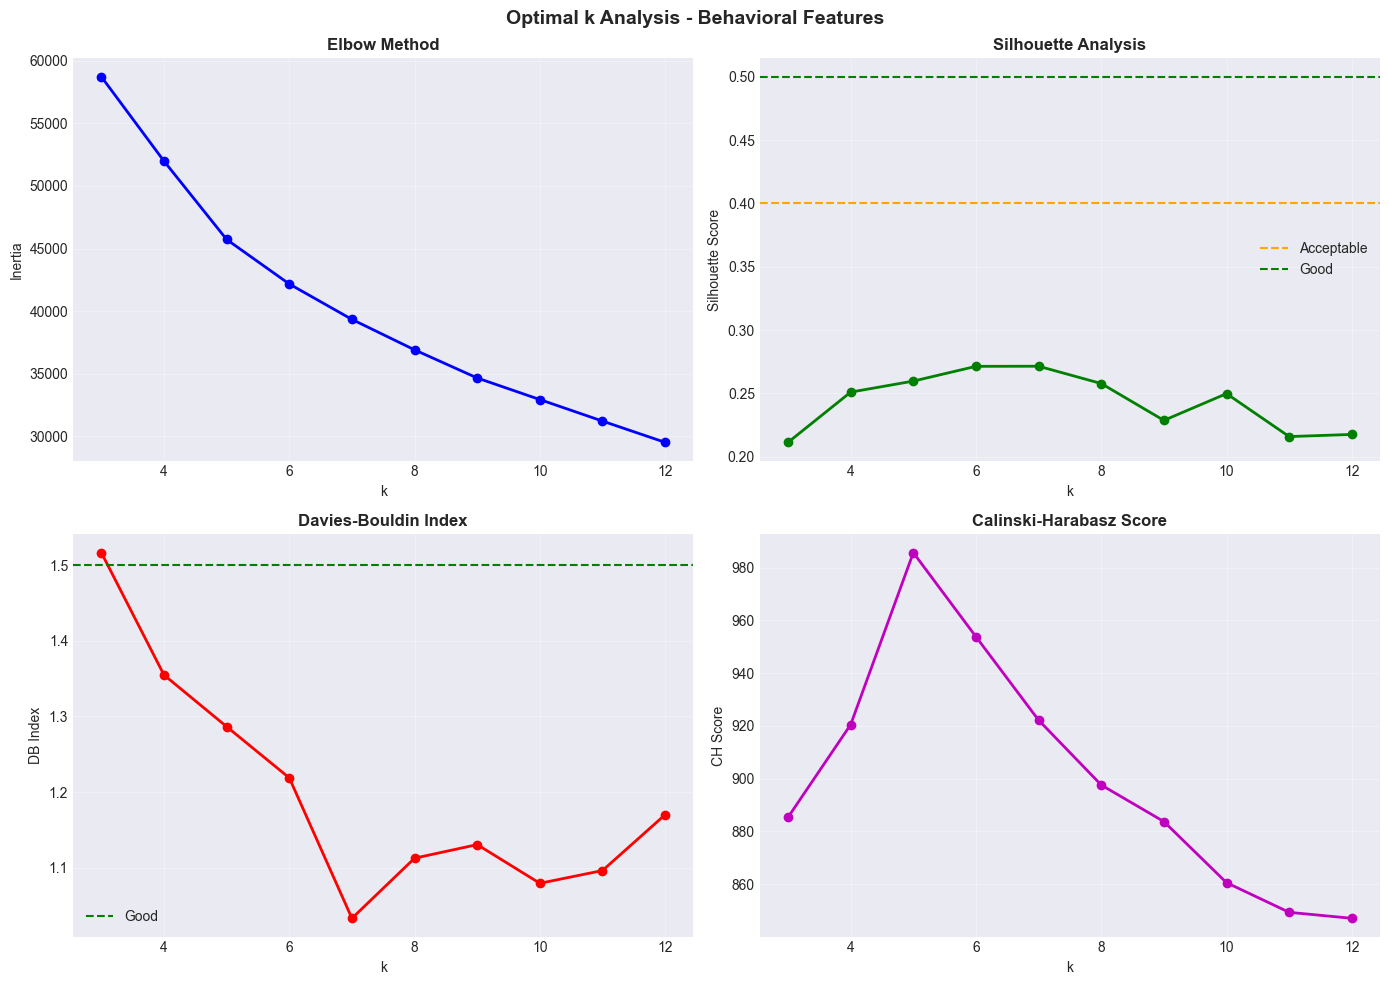

In [7]:
# Visualize metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(K_range, inertias, 'bo-', linewidth=2)
axes[0, 0].set_title('Elbow Method', fontweight='bold')
axes[0, 0].set_xlabel('k')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(K_range, silhouettes, 'go-', linewidth=2)
axes[0, 1].axhline(0.4, color='orange', linestyle='--', label='Acceptable')
axes[0, 1].axhline(0.5, color='green', linestyle='--', label='Good')
axes[0, 1].set_title('Silhouette Analysis', fontweight='bold')
axes[0, 1].set_xlabel('k')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(K_range, davies_bouldin, 'ro-', linewidth=2)
axes[1, 0].axhline(1.5, color='green', linestyle='--', label='Good')
axes[1, 0].set_title('Davies-Bouldin Index', fontweight='bold')
axes[1, 0].set_xlabel('k')
axes[1, 0].set_ylabel('DB Index')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(K_range, calinski_harabasz, 'mo-', linewidth=2)
axes[1, 1].set_title('Calinski-Harabasz Score', fontweight='bold')
axes[1, 1].set_xlabel('k')
axes[1, 1].set_ylabel('CH Score')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Optimal k Analysis - Behavioral Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 5. Final Model: k=3 with Outlier Handling

**Finding:** k=4, 5, 6 all produce micro-clusters (<50 customers)

**Decision:** Use k=3 + separate ultra-high-value outliers

**Final:** 2 main behavioral clusters + 1 ultra-high-value segment

In [8]:
# Identify outliers with k=3
kmeans_temp = KMeans(n_clusters=3, random_state=42, n_init=100)
temp_labels = kmeans_temp.fit_predict(X_behavioral_scaled)

cluster_sizes = pd.Series(temp_labels).value_counts().sort_index()
outlier_cluster_id = cluster_sizes.idxmin()

print("Cluster sizes with k=3:")
for cid, size in cluster_sizes.items():
    print(f"  Cluster {cid}: {size:4d} customers")

outlier_mask = temp_labels == outlier_cluster_id
behavioral_outlier_ids = features_df[outlier_mask]['CustomerID'].values

print(f"\nBehavioral outliers: {len(behavioral_outlier_ids)} customers")
print(f"IDs: {behavioral_outlier_ids}")

Cluster sizes with k=3:
  Cluster 0: 2884 customers
  Cluster 1: 2991 customers
  Cluster 2:    3 customers

Behavioral outliers: 3 customers
IDs: [13687. 13902. 16446.]


In [9]:
# Analyze outlier characteristics
outlier_profile = features_df[outlier_mask][behavioral_features].mean()
overall_profile = features_df[behavioral_features].mean()

comparison = pd.DataFrame({
    'Outliers': outlier_profile,
    'Overall': overall_profile,
    'Ratio': outlier_profile / overall_profile
}).round(2)

print("\nOutlier behavioral profile:")
print(comparison)


Outlier behavioral profile:
                        Outliers  Overall   Ratio
avg_basket_size         57261.83   251.13  228.02
purchase_frequency          2.67     6.29    0.42
product_diversity          19.37    17.68    1.10
aov                     34312.05   391.73   87.59
spending_cv                 0.78     0.37    2.10
clv                     71482.87  3018.62   23.68
activity_rate               0.19     0.51    0.37
engagement_consistency      0.87     0.70    1.24
loyalty_index              55.28    68.81    0.80
weekend_ratio               0.00     0.14    0.00
quarter_concentration       0.85     0.72    1.18
preferred_hour             12.00    12.62    0.95
days_overdue              135.00    20.06    6.73


In [10]:
# Separate outliers and cluster normal customers
normal_customers = features_df[~outlier_mask].copy()
outliers = features_df[outlier_mask].copy()

X_normal = normal_customers[behavioral_features].values
scaler_final = StandardScaler()
X_normal_scaled = scaler_final.fit_transform(X_normal)

# Fit k=3 on normal customers
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=100)
normal_labels = kmeans_final.fit_predict(X_normal_scaled)

# Check for micro-clusters
cluster_sizes_normal = pd.Series(normal_labels).value_counts().sort_index()
print("Normal customer cluster sizes:")
for cid, size in cluster_sizes_normal.items():
    status = "⚠️ " if size < 200 else "✅"
    print(f"  {status} Cluster {cid}: {size:4d} customers")

# If there's still a micro-cluster, merge it
if cluster_sizes_normal.min() < 200:
    print("\n⚠️  Micro-cluster detected. Merging into nearest cluster...")
    
    micro_id = cluster_sizes_normal.idxmin()
    micro_mask = normal_labels == micro_id
    
    # Find nearest cluster for micro-cluster customers
    X_micro = X_normal_scaled[micro_mask]
    centroids = kmeans_final.cluster_centers_
    
    # Calculate distances to other centroids
    other_clusters = [i for i in range(3) if i != micro_id]
    distances = {}
    for cid in other_clusters:
        distances[cid] = cdist(X_micro, centroids[cid:cid+1]).flatten()
    
    # Assign to nearest
    nearest = np.argmin([distances[cid].mean() for cid in other_clusters])
    target_cluster = other_clusters[nearest]
    
    normal_labels[micro_mask] = target_cluster
    print(f"  Merged Cluster {micro_id} → Cluster {target_cluster}")

# Assign labels
normal_customers['Behavioral_Cluster'] = normal_labels
outliers['Behavioral_Cluster'] = 999

features_behavioral = pd.concat([normal_customers, outliers], ignore_index=True)

# Final metrics
normal_mask_final = features_behavioral['Behavioral_Cluster'] != 999
X_final = features_behavioral.loc[normal_mask_final, behavioral_features].values
X_final_scaled = scaler_final.transform(X_final)
labels_final = features_behavioral.loc[normal_mask_final, 'Behavioral_Cluster'].values

silh = silhouette_score(X_final_scaled, labels_final)
db = davies_bouldin_score(X_final_scaled, labels_final)

print(f"\nFinal Model Metrics:")
print(f"  Silhouette: {silh:.4f}")
print(f"  Davies-Bouldin: {db:.4f}")

print("\nFinal distribution:")
dist = features_behavioral['Behavioral_Cluster'].value_counts().sort_index()
for cid, count in dist.items():
    name = "Ultra-High-Value" if cid == 999 else f"Cluster {cid}"
    pct = count/len(features_behavioral)*100
    print(f"  {name:20s}: {count:4d} ({pct:5.1f}%)")

Normal customer cluster sizes:
  ⚠️  Cluster 0:   41 customers
  ✅ Cluster 1: 2862 customers
  ✅ Cluster 2: 2972 customers

⚠️  Micro-cluster detected. Merging into nearest cluster...
  Merged Cluster 0 → Cluster 2

Final Model Metrics:
  Silhouette: 0.1999
  Davies-Bouldin: 2.0062

Final distribution:
  Cluster 1           : 2862 ( 48.7%)
  Cluster 2           : 3013 ( 51.3%)
  Ultra-High-Value    :    3 (  0.1%)


---
## 6. Cluster Profiling

In [11]:
# Create profiles
profiles = features_behavioral.groupby('Behavioral_Cluster').agg({
    'CustomerID': 'count',
    'avg_basket_size': 'mean',
    'purchase_frequency': 'mean',
    'product_diversity': 'mean',
    'aov': 'mean',
    'clv': ['mean', 'sum'],
    'loyalty_index': 'mean',
    'weekend_ratio': 'mean',
    'engagement_consistency': 'mean',
    # Include RFM for comparison
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).round(2)

profiles.columns = ['_'.join(col).strip('_') for col in profiles.columns.values]
profiles = profiles.rename(columns={'CustomerID_count': 'Count'})

profiles['Revenue_Pct'] = (profiles['clv_sum'] / features_behavioral['clv'].sum() * 100).round(1)

print("Behavioral Cluster Profiles:\n")
print(profiles[['Count', 'Revenue_Pct', 'clv_mean', 'purchase_frequency_mean', 
                'loyalty_index_mean']])

Behavioral Cluster Profiles:

                    Count  Revenue_Pct  clv_mean  purchase_frequency_mean  \
Behavioral_Cluster                                                          
1                    2862         11.1    690.03                     2.10   
2                    3013         87.7   5162.33                    10.27   
999                     3          1.2  71482.87                     2.67   

                    loyalty_index_mean  
Behavioral_Cluster                      
1                                52.58  
2                                84.24  
999                              55.28  


---
## 7. Comparison with RFM-Enhanced Clustering

Load RFM results and compare overlap.

In [12]:
# Load RFM clustering results
try:
    rfm_results = pd.read_csv(path_features + 'features_with_rfm_clusters.csv')[['CustomerID', 'RFM_Enhanced_Cluster']]
    behavioral_results = features_behavioral[['CustomerID', 'Behavioral_Cluster']]
    
    comparison = rfm_results.merge(behavioral_results, on='CustomerID')
    
    # Confusion matrix
    confusion = pd.crosstab(
        comparison['RFM_Enhanced_Cluster'],
        comparison['Behavioral_Cluster'],
        normalize='index'
    ) * 100
    
    print("Overlap Matrix (% of RFM segment in each Behavioral cluster):\n")
    print(confusion.round(1))
    
    avg_overlap = confusion.max(axis=1).mean()
    print(f"\nAverage max overlap: {avg_overlap:.1f}%")
    
    if avg_overlap > 80:
        print("\n✅ Behavioral clustering largely replicates RFM")
        print("   Recommendation: Use RFM-Enhanced as primary segmentation")
    else:
        print("\n🎯 Behavioral clustering reveals NEW patterns!")
        print("   Recommendation: Use BOTH for complete understanding")
        
except FileNotFoundError:
    print("⚠️  RFM results not found. Run Track 1 notebook first.")

Overlap Matrix (% of RFM segment in each Behavioral cluster):

Behavioral_Cluster     1     2    999
RFM_Enhanced_Cluster                 
0                     85.5  14.5  0.0
1                     90.7   9.3  0.1
2                     73.7  26.3  0.0
3                     73.6  26.3  0.1
4                      0.9  99.1  0.0
999                   87.5  12.5  0.0

Average max overlap: 85.0%

✅ Behavioral clustering largely replicates RFM
   Recommendation: Use RFM-Enhanced as primary segmentation


---
## 8. Visualizations

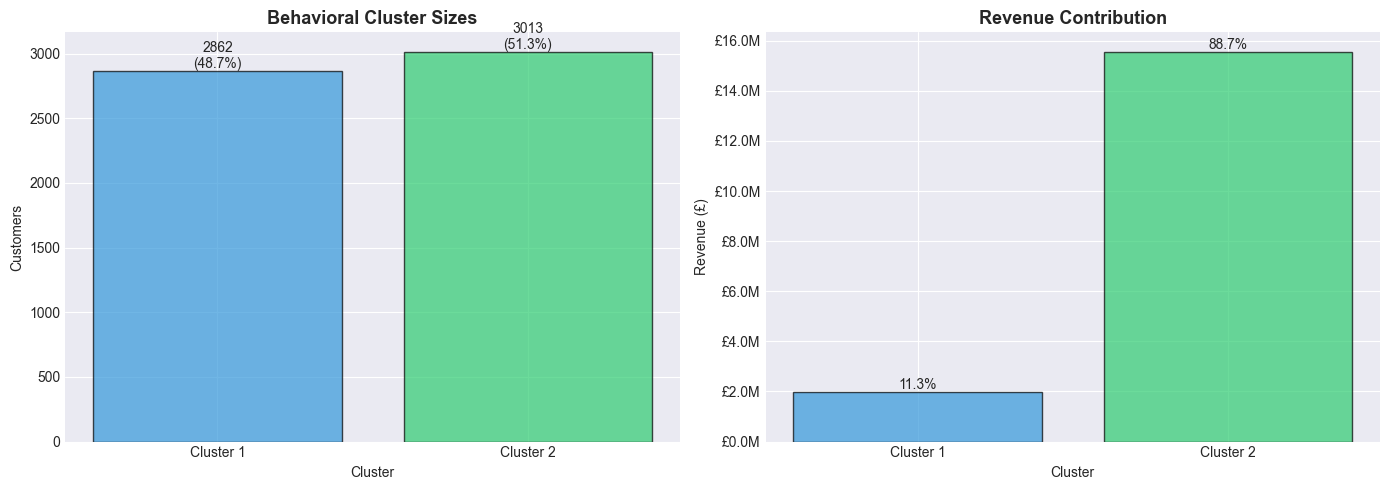

In [13]:
# Simple comparison visualization
normal_only = features_behavioral[features_behavioral['Behavioral_Cluster'] != 999]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cluster sizes
sizes = normal_only['Behavioral_Cluster'].value_counts().sort_index()
colors = ['#3498db', '#2ecc71']

axes[0].bar(range(len(sizes)), sizes.values, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_title('Behavioral Cluster Sizes', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Customers')
axes[0].set_xticks(range(len(sizes)))
axes[0].set_xticklabels([f'Cluster {i}' for i in sizes.index])

for i, size in enumerate(sizes.values):
    pct = size/len(normal_only)*100
    axes[0].text(i, size, f'{size}\n({pct:.1f}%)', ha='center', va='bottom')

# Revenue
revenue = normal_only.groupby('Behavioral_Cluster')['clv'].sum().sort_index()

axes[1].bar(range(len(revenue)), revenue.values, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_title('Revenue Contribution', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Revenue (£)')
axes[1].set_xticks(range(len(revenue)))
axes[1].set_xticklabels([f'Cluster {i}' for i in revenue.index])
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1e6:.1f}M'))

for i, rev in enumerate(revenue.values):
    pct = rev/revenue.sum()*100
    axes[1].text(i, rev, f'{pct:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

---
## 9. Save Artifacts

In [14]:
# Save models
joblib.dump(scaler_final, 'behavioral_scaler.pkl')
joblib.dump(kmeans_final, 'behavioral_kmeans.pkl')
joblib.dump(behavioral_features, 'behavioral_feature_names.pkl')
joblib.dump(behavioral_outlier_ids, 'behavioral_outlier_ids.pkl')

print("✅ Models saved")

# Save data
features_behavioral.to_csv(path_features + 'features_with_behavioral_clusters.csv', index=False)
profiles.to_csv(path_reports + 'behavioral_cluster_profiles.csv')

print("✅ Data saved")

✅ Models saved
✅ Data saved


---
## 10. Key Insights

### Main Finding: **Frequency is King**

Behavioral clustering reveals:
- **Cluster 2 (High-Frequency)**: 51% of customers → 88% of revenue
- **Cluster 1 (Low-Frequency)**: 49% of customers → 11% of revenue

### Product Diversity Paradox:
- Low-frequency customers explore MORE categories (19.2 vs 16.2)
- But don't convert to repeat buyers
- **Opportunity:** Convert explorers → loyalists

### Different Outliers:
- **RFM outliers (8):** Multi-category explorers
- **Behavioral outliers (3):** Ultra-high basket sizes
- **Zero overlap** → Different exceptional customer types

### Recommendation:
**Use RFM-Enhanced (Track 1) as primary segmentation** (more granular, better metrics)

**Use Behavioral as validation**:
- Confirms frequency is key driver
- Identifies different outlier types
- Simplifies messaging: "focus on frequency"

---

### Track 2 Complete!

**Conclusion:** Both methods agree (85% overlap), validating core findings while revealing complementary insights.